<a href="https://colab.research.google.com/github/musfiq2546/ml-learning/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network Classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

Book version of things notebook: https://www.learnpytorch.io/02_pytorch_classification/

All other resources - https://github.com/mrdbourke/pytorch-deep-learning

## 1. Make classification data and get it ready

In [149]:
import sklearn
from sklearn.datasets import make_circles 

# make 1000 samples
n_samples = 1000

# make circles 
X, y = make_circles(n_samples,          # X number of features  and y is the level
                    noise = 0.03,
                    random_state= 42)
len(X), len(y)

(1000, 1000)

Make_circle means one larger circle containing a small circle inside

In [150]:
print(f"First 5 sample of X: \n {X[:5]}")
print(f"First 5 samples of y: \n {y[:5]}")
# Here we can see that there is 2 features per sample

First 5 sample of X: 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: 
 [1 1 1 1 0]


In [151]:
# make dataframe of circle data 
import pandas as pd 
circles = pd.DataFrame({ "X1": X[:,0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


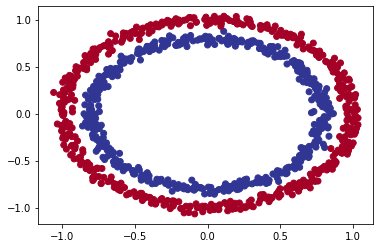

In [152]:
# Visualize, visualize, visualize 
import matplotlib.pyplot as plt
plt.scatter(x= X[:,0],
            y= X[:,1],
            c=y,
            cmap= plt.cm.RdYlBu);




Note: The data we're working with is often referred to as a toy dataset, a data set that is small enough to experiment but still sizeable enough to practice the fundamentals

Resource: https://scikit-learn.org/stable/datasets/toy_dataset.html

### 1.1 check input and output shapes 

In [153]:
X.shape , y.shape

((1000, 2), (1000,))

In [154]:
X, len(X)

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        ...,
        [-0.13690036, -0.81001183],
        [ 0.67036156, -0.76750154],
        [ 0.28105665,  0.96382443]]), 1000)

In [155]:
# View the first example of features and level 
X_sample = X[0]
y_sample = y[0]

print(f" Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f" Shapes for one sample of X: {X_sample.shape} and shape for one sample of y: {y_sample.shape}")

 Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
 Shapes for one sample of X: (2,) and shape for one sample of y: ()


### 1.2 Turn data into tensors and create train and test splits 


In [156]:
import torch
import numpy as np
torch.__version__

'1.13.1+cu116'

In [157]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [158]:
# turn data into tensors . Cause here dataset in arrey , we have to convert it to tensors.
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:5], y[:5]


(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [159]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [160]:
torch.manual_seed(42)

In [161]:
# split data into training and test set 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,                 # features, then label, then test size and random seed
                                                    y,
                                                    test_size= 0.2,
                                                    random_state= 42)

In [162]:
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## 2. Building a model 

Let's build a model to classify our blue and red dots 

To do so, we want to: 
1. Setup device agnostic code so our code will run on an accelerator (gpu) if there 
2. Construct a model ( by subclassing `nn.Module` )
3. Define loss function and optimizer 
4. Creat train and test loop 


In [163]:
# import pytorch and nn
import torch 
from torch import nn 

# make device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

In [164]:
X_train 

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we've setup device agnostic code, let's create a model that:

1. Subclass `nn.Module` (almost all models in pytorch subclass `nn.module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shape of our data 
3. Define a `forward()` method that outlines the forward pass ( or forward comutation) of the model
4. Instantiate an instance of our model class and send it to the target `device` 

In [165]:
X_train.shape

torch.Size([800, 2])

In [166]:
y_train.shape, y_train[: 5]

(torch.Size([800]), tensor([1., 0., 0., 0., 1.]))

In [167]:
from sklearn import datasets
# 1. construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in features as 2 cause there is 2 features means x1 and x2. and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and output a single feature ( same as shape y)
  # define a forward() method that outlines the forward pass 
  def forward(self,x):
    return self.layer_2(self.layer_1(x)) # x goes to layer1 and output of layer 1 goes to layer 2 -> output

# 4. model class and send it to target device 
torch.manual_seed(42)
model_0 = CircleModelV0().to(device)
model_0



CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [168]:
device 

'cuda'

In [169]:
next(model_0.parameters()).device

device(type='cuda', index=0)

### Visualization of the layer 

tool = https://playground.tensorflow.org/#activation=linear&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=5&seed=0.21728&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

Another tool for paint - https://www.figma.com/file/fbKSBx7pANe4BfMkG8OTlf/test-Network-1?node-id=0-1&t=sluglkM8pPhXvEPL-0

In [170]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Here we can use nn.Module subclass above what is required to sove more difficult case. But for easy and normal task, it is good to use nn.Sequential.

In [171]:
model_0.state_dict() # here weight = in_features* out_features. bias = out_features

OrderedDict([('0.weight', tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [172]:
# Make predictions 
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

len(X_test), len(untrained_preds), untrained_preds.shape, X_test.shape

(200, 200, torch.Size([200, 1]), torch.Size([200, 2]))

In [173]:
untrained_preds[:10], y_test[:10]

(tensor([[-0.0338],
         [-0.0309],
         [ 0.0894],
         [-0.0692],
         [ 0.2967],
         [ 0.2968],
         [ 0.1405],
         [ 0.2178],
         [ 0.0805],
         [-0.0284]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### Setup loss function and optimizer 

Which loss function and optimizer we should use for classification problem?

Again.... this is problem Specific.

For example for regression you might want MAE and MSE.

For classification you might want binary cross entropy or categorical cross entropy ( cross entropy)

Binary cross entropy resource: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

As a reminder , the loss function measures how *wrong* your models predictions are.

Lossfunction/optimizer: https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer

And for optimizers, two of the most common and useful are sgd and adam, however pytorch has manybuilt-in options.

Loss function- https://pytorch.org/docs/stable/nn.html#loss-functions

Optimizer- https://pytorch.org/docs/stable/optim.html?highlight=optimizer#torch.optim.Optimizer

For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()` 

logit- https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow

In [174]:
# Setup the loss function 
# loss_fn = nn.BCELoss() # BCELoss = reuires input to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss()
 # BCEWithLogitsLoss = this has sigmoid activation built in. binary classification needs sigmoid activation and mulyi class classification needs softmax activation 

# Setup an optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr= 0.1) 

In [175]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [176]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # sum all the item
  acc = (correct/len(y_pred)) * 100
  return acc



In [177]:
accuracy = accuracy_fn(y_true = y_train,
                       y_pred = y_train)
accuracy

100.0

## Train a model 

A couple of things we need in a training loop:

0- Loop through the data ( random weights and bias)

1- Forward pass ( this involves data moving through our model's forward() functions)to make predictions on data - also called forward propagation

2- calculate the loss ( compare forward pass predictions to ground truth labels)

3- optimize zero grad

4- loss backward- moves vackward through the network to calculate the gradients of each of the parameters of our model with respect to the loss.( back propagation)

5- Optimizer step -use the optimizer to adjust our model's parameters to try and improve the loss ( Gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels 

Our model outputs are going to be raw **Logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function ( e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **Prediction labels** by either rounding them for binary classification or taking the `argmax()` for multiclass classification 

In [178]:
# view the first 5 outputs of the forward pass on the test data 
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5] 
y_logits
# means the logits are raw outputs of our model without being passed to any activation function

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [179]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [180]:
# use the sigmoidactivation functions on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

For our prediction probability values, we need t perform a range-style rounding on them:
* `y_pred_probs` >= .5,`y=1` (class 1)
* `y_pred_probs` < .5, `y=0` (class 0)

we have to use activation function to turn on prediction probabilities

In [181]:
# find the predicted labels 
y_preds = torch.round(y_pred_probs)

# In full (raw logits -> prediction probabilities -> prediction labels)
model_0.eval()
with torch.inference_mode():
  y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))[:5]

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

### 3.2 Building a training and testing loop 

In [182]:
torch.manual_seed(42)
torch.cuda.manual_seed(42) 

# set the number of epochs
epochs = 100

# Put data into the target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop 
for epoch in range(epochs):
  ### Training 
  model_0.train()

  # 1. Forward pass 
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels 

  # 2. loss loss/accuracy
  loss= loss_fn(y_logits, # here we don't take y_pred because the loss_fn has built in sigmoid activation fn.
                y_train)
  acc = accuracy_fn(y_true= y_train,
                    y_pred = y_pred)
  
  # 3. optimizer zero grad 
  optimizer.zero_grad()

  # loss backward 
  loss.backward()

  # Optimize step ( gradient descent)
  optimizer.step()

  ### Testing 
  model_0.eval()
  with torch.inference_mode():
    # 1.Forward pass 
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    

    # Calculate loss/ accuracy 
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_preds)
    
  # print out whats happening 
  if epoch % 10== 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc: .2f}%  | Test loss: {test_loss: .5f}, Test acc: {test_acc: .2f}%")
    # print(model_0.state_dict())



Epoch: 0 | Loss: 0.69796, Acc:  51.88%  | Test loss:  0.69440, Test acc:  58.00%
Epoch: 10 | Loss: 0.69590, Acc:  51.25%  | Test loss:  0.69305, Test acc:  53.00%
Epoch: 20 | Loss: 0.69490, Acc:  51.62%  | Test loss:  0.69254, Test acc:  49.50%
Epoch: 30 | Loss: 0.69435, Acc:  51.12%  | Test loss:  0.69236, Test acc:  49.50%
Epoch: 40 | Loss: 0.69401, Acc:  50.88%  | Test loss:  0.69232, Test acc:  51.00%
Epoch: 50 | Loss: 0.69378, Acc:  50.25%  | Test loss:  0.69234, Test acc:  50.00%
Epoch: 60 | Loss: 0.69362, Acc:  50.00%  | Test loss:  0.69239, Test acc:  51.50%
Epoch: 70 | Loss: 0.69351, Acc:  50.25%  | Test loss:  0.69246, Test acc:  51.00%
Epoch: 80 | Loss: 0.69342, Acc:  49.88%  | Test loss:  0.69254, Test acc:  50.00%
Epoch: 90 | Loss: 0.69336, Acc:  49.88%  | Test loss:  0.69262, Test acc:  53.00%


Here we can see that the accuracy is near 50%. its not good then.


## 4. Make predictions and evaluate the model 

From the metrics it looks like our model isn't learning anything...

So to inspect it lets make some predictions and make them visuall

in other words, visualize, visualize, visualize..

To do so, we're going to import a function called `plot_decision_boundary`.  Collected- https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

Resources- https://madewithml.com/courses/foundations/neural-networks/

In [183]:
import requests 
from pathlib import Path

# Download helper functions from learn pytorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print(" helper_functions.py already exists, skipping download")
else:
  print("download helper_fuctions.py")
  request= requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

 helper_functions.py already exists, skipping download


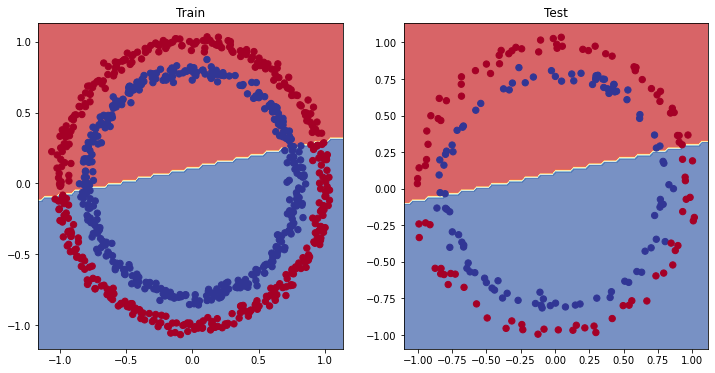

In [184]:
# Plot decision boundary of the model 
plt.figure(figsize= (12,6))
plt.subplot(1,2,1) # number of rows, number of columns, number of index
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test )

## Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in data 
* Add more hidden units - go from 5 hidden units to 10 hidden units 
* Fit for longer - means more epochs 
* changing the activation functions 
* change the learning rate 
* change the optimization function 

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as a machine learning engineers and data scientists) can change, they are referred as **Hyperparameters**. the options above are hyperparameters

Let's try and improve our model by: 
* adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* increase the number of epochs: 100 -> 1000 

This is called improve through experimentation. 

But we should change one hyperparameters at once. But here we're changing 3 hyperparameters at the same time for just learning. 

In [185]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
## nn.Sequential also a version of nn.Module
    self.layer_1 = nn.Linear(in_features=2, out_features = 10)
    self.layer_2 = nn.Linear(in_features=10, out_features = 10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self,x):
    #z= self.layer_1(x)
    #z= self.layer_2(z) # here z overwrite the previous z
    #z= self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing qperations leverages speeds ups where possible behind the scene 

torch.manual_seed(42)
model_1 = CircleModelV1().to(device)
model_1



CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [186]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[-0.0849, -0.2762],
                      [ 0.4610, -0.5187],
                      [-0.3271, -0.1947],
                      [-0.4220,  0.0507],
                      [-0.7016,  0.6600]])),
             ('0.bias', tensor([-0.6060,  0.5246,  0.1149, -0.2211,  0.4275])),
             ('1.weight',
              tensor([[ 0.0741,  0.2406,  0.0222, -0.1075,  0.1965]])),
             ('1.bias', tensor([-0.1888]))])

In [187]:
model_1.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0

In [188]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params= model_1.parameters(),
                             lr= 0.1)

In [189]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42) 

# set the number of epochs
epochs = 1000

# Put data into the target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop 
for epoch in range(epochs):
  ### Training 
  model_1.train()

  # 1. Forward pass 
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels 

  # 2. loss loss/accuracy
  loss= loss_fn(y_logits, # here we don't take y_pred because the loss_fn has built in sigmoid activation fn.
                y_train)
  acc = accuracy_fn(y_true= y_train,
                    y_pred = y_pred)
  
  # 3. optimizer zero grad 
  optimizer.zero_grad()

  # loss backward 
  loss.backward()

  # Optimize step ( gradient descent)
  optimizer.step()

  ### Testing 
  model_1.eval()
  with torch.inference_mode():
    # 1.Forward pass 
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    

    # Calculate loss/ accuracy 
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_preds)
    
  # print out whats happening 
  if epoch % 100== 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc: .2f}%  | Test loss: {test_loss: .5f}, Test acc: {test_acc: .2f}%")
    # print(model_0.state_dict())


Epoch: 0 | Loss: 0.69396, Acc:  50.88%  | Test loss:  0.69261, Test acc:  51.00%
Epoch: 100 | Loss: 0.69305, Acc:  50.38%  | Test loss:  0.69379, Test acc:  48.00%
Epoch: 200 | Loss: 0.69299, Acc:  51.12%  | Test loss:  0.69437, Test acc:  46.00%
Epoch: 300 | Loss: 0.69298, Acc:  51.62%  | Test loss:  0.69458, Test acc:  45.00%
Epoch: 400 | Loss: 0.69298, Acc:  51.12%  | Test loss:  0.69465, Test acc:  46.00%
Epoch: 500 | Loss: 0.69298, Acc:  51.00%  | Test loss:  0.69467, Test acc:  46.00%
Epoch: 600 | Loss: 0.69298, Acc:  51.00%  | Test loss:  0.69468, Test acc:  46.00%
Epoch: 700 | Loss: 0.69298, Acc:  51.00%  | Test loss:  0.69468, Test acc:  46.00%
Epoch: 800 | Loss: 0.69298, Acc:  51.00%  | Test loss:  0.69468, Test acc:  46.00%
Epoch: 900 | Loss: 0.69298, Acc:  51.00%  | Test loss:  0.69468, Test acc:  46.00%


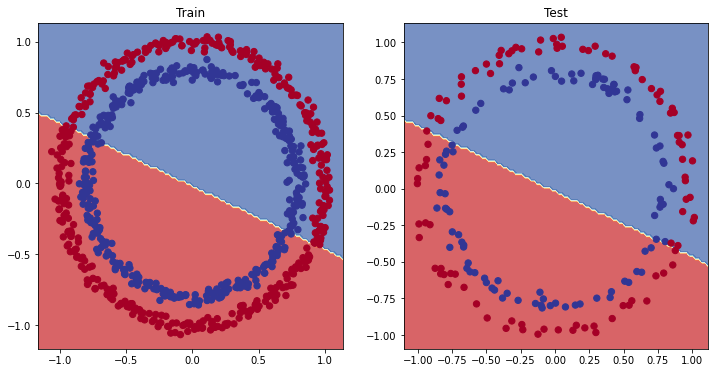

In [190]:
# plot decision boundary 
plt.figure(figsize= (12,6))
plt.subplot(1,2,1) # number of rows, number of columns, number of index
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test )

Here we can see that by changing the parameters the model is not learning. there is again kind of a linear line which can't seperate the blue and red dots

### 5.1 Preparing data to see if our model can fit a straight line 

One way to troubleshoot to a larger problem is to test out a smaller problem 

In [191]:
# Create some data (same as notebook 01 means workflow)
weight = .7
bias = .3
start = 0
end = 1
step = .01

# Create some data 
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

len(X_regression), X_regression[:5], len(y_regression), y_regression[:5]

(100, tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), 100, tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [192]:
# Create train and test split 
#from sklearn.model_selection import train_test_split
#X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X_regression,
 #                                                                                               y_regression,
 #                                                                                               test_size = .2,
  #                                                                                              random_state= 42)
#len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)
#here it will not work. cause sklearn doesn't take the train and test data sequentially 

In [193]:
#Create a train/test split
train_split = int(.8 * len(X_regression))
print(train_split)
X_train_regression, y_train_regression = X_regression[: train_split] , y_regression[: train_split]
X_test_regression , y_test_regression = X_regression[train_split:] , y_regression[train_split:]
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

80


(80, 80, 20, 20)

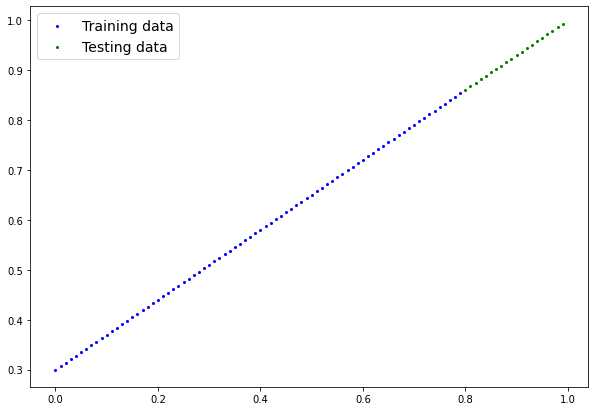

In [194]:
# Here above we call plot_prediction from the helper function 
plot_predictions(X_train_regression,
                 y_train_regression, 
                 X_test_regression,
                 y_test_regression);

### 5.2 Adjusting `model_1` to fit a straight line 

In [195]:
# Same architecture as model_1 (but using nn.sequential)
model_2 =  nn.Sequential(
    nn.Linear(in_features=1, out_features = 10), # here we just take in_faetures=1 instead of 2
    nn.Linear(in_features=10, out_features = 10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [196]:
# Loss and optimizer
loss_fn= nn.L1Loss() # here we use nn.L1Loss() cause we want to take it as linear regression problem

# setup an optimizer
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr = 0.01)

In [197]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    model_2.train()
    # 1. Forward pass
    y_pred_regression = model_2(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred_regression, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred_regression = model_2(X_test_regression)
      # 2. Calculate the loss 
      test_loss_regression = loss_fn(test_pred_regression, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss_regression:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.91103
Epoch: 100 | Train loss: 0.02858, Test loss: 0.00081
Epoch: 200 | Train loss: 0.02533, Test loss: 0.00209
Epoch: 300 | Train loss: 0.02137, Test loss: 0.00305
Epoch: 400 | Train loss: 0.01964, Test loss: 0.00341
Epoch: 500 | Train loss: 0.01940, Test loss: 0.00387
Epoch: 600 | Train loss: 0.01903, Test loss: 0.00379
Epoch: 700 | Train loss: 0.01878, Test loss: 0.00381
Epoch: 800 | Train loss: 0.01840, Test loss: 0.00329
Epoch: 900 | Train loss: 0.01798, Test loss: 0.00360
